In [1]:
import math
import torch
import gpytorch
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 

from GPyEm import GPE_ensemble as GPE
from FSGPLVM import FSGPLVM as LVM

In [2]:
import sklearn.metrics as sk

### Fully supervised GPLVM (we should come up with a better acronym/name)

Observations:
$$Y = [y_1,...,y_N], \ y_n \in R^{p}$$
Model parameters
$$X = [x_1,...,x_N], \ x_n \in R^{p\times q}$$
Latent parameters/features
$$L = [l_1,...,l_N], \ l_n \in R^{d }$$
With $d<q$ and $L\sim N(0,I)$.

We want to find a function $f_\theta$ such that:
$$ Y = f_\theta(X,L)+\epsilon $$
Let's make $f$ a GP, as we like to, with mean $m_\theta(X,L)$ and covariance $K_\theta((X,L),(X',L'))$
We would like to learn $L$ and $\theta$ (the hyper-parameters). 

As a cost function we use the likelihood
$$p(Y,L|X) = p(Y|L,X)p(L) $$
and as $f$ is a GP,
$$p(Y|L,X) \sim N(m_\theta(X,L), K_\theta((X,L),(X,L)))$$

Taking the log we have
$$\log p(Y,L|X) = \log p(Y|L,X)+\log p(L) $$
$$ = -\frac{NP}{2}\log(2\pi)-\frac{1}{2}\log|K_\theta|-\frac{1}{2}(Y-m_\theta(X,L))^\top\ K_\theta^{-1}(Y-m_\theta(X,L))-\frac{N*LDIM}{2}\log(2\pi)-\frac{1}{2}\log|I|-\frac{1}{2}(L)^\top I^{-1}(L)) $$


to calculate $\log |K|$ we use the fact that $\log |K| = 2\Sigma (\log\mathrm{diag}(L)_i)$, where $L$ is the cholesky decomposition of $K$.

In [3]:
def multivariate_ll(y,mu,K,K_inv=None):
    det = 2*torch.sum(torch.log(torch.diag(torch.linalg.cholesky(K))))
    if K_inv==None:
        ll = -((y.shape[0]*y.shape[1])/2)*torch.log(2*torch.tensor(torch.pi))-0.5*y.shape[1]*det-0.5*torch.sum(torch.diag(torch.matmul((y-mu).T,torch.linalg.solve(K,y-mu))))
        #ll = -(y.shape[0]/2)*torch.log(2*torch.tensor(torch.pi))-0.5*det-0.5*torch.matmul((y-mu).T,torch.linalg.solve(K,y-mu))
        
    return ll

In [4]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel



def rbf(X1,L1,X2,L2,scaling,lengthscale,p1,p2):
    X1=X1/torch.sqrt(lengthscale)
    X2=X2/torch.sqrt(lengthscale)
    X_1 = (torch.cat((X1,torch.repeat_interleave(L1,p1,dim=0)),axis=1)).detach().numpy()
    X_2 = (torch.cat((X2,torch.repeat_interleave(L2,p2,dim=0)),axis=1)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf

def rbf(X1,L1,X2,L2,scaling,lengthscale,p1,p2):
    X_1 = (torch.cat((X1,torch.repeat_interleave(L1,p1,dim=0)),axis=1)/torch.sqrt(lengthscale)).detach().numpy()
    X_2 = (torch.cat((X2,torch.repeat_interleave(L2,p2,dim=0)),axis=1)/torch.sqrt(lengthscale)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf

def rbf2(X1,X2,scaling,lengthscale):

    X_1 = (X1/torch.sqrt(lengthscale)).detach().numpy()
    X_2 = (X2/torch.sqrt(lengthscale)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf


def rbf(X1,X2,scaling,lengthscale):

    X_1 = X1/lengthscale
    X_2 = X2/lengthscale
    rbf = scaling * torch.exp(-0.5*torch.cdist(X_1,X_2,p=2)**2)

    return rbf



For the linear kernel we don't really have any separation possibilities that are useful to us from an inverting persepctive, as far as I can tell? 
$$K_{ij}=x_i^\top x_j + l_i^\top l_j$$

So we don't get much in the way of help here.

In [5]:
def linear(X1,L1,X2,L2,X_length,L_length,p1,p2):
    
    L1=L1/torch.sqrt(L_scale)
    X1=X1/torch.sqrt(X_scale)
    X_1 = torch.cat((X1,torch.repeat_interleave(L1,p1)[:,None]),axis=1)

    L2=L2/torch.sqrt(L_scale)
    X2=X2/torch.sqrt(X_scale)
    X_2 = torch.cat((X2,torch.repeat_interleave(L2,p2)[:,None]),axis=1)
    
    rbf =  torch.matmul(X_1, X_2.T) 
    return rbf

sample $L$ and $X$ from $U[-1,1]$

Here we do $x_i \neq x_j$, just for the sake of it

Posterior mean: $$m(X^*,X)+K((X^*,L^*),(X,L))(K((X,L),(X,L))+\sigma^2I)^{-1}(Y-m(X,X))$$

Posterior covar: $$K((X^*,L^*),(X^*,L^*))+\sigma^2 - K((X^*,L^*),(X,L))(K((X,L),(X,L))+\sigma^2I]^{-1}K((X^*,L^*),(X,L))^\top$$

In [6]:
def posterior_theta(Y,X_test,L_test,p_test,X_train,L_train,p_train,scaling,lengthscale,sigma2,mean):
    K = rbf(X_train,L_train,X_train,L_train,scaling,lengthscale,p_train,p_train)+sigma2*torch.eye(X_train.shape[0])
    K_s = rbf(X_test,L_test,X_train,L_train,scaling,lengthscale,p_test,p_train)
    K_ss = rbf(X_test,L_test,X_test,L_test,scaling,lengthscale,p_test,p_test)

    mean_p = mean+torch.matmul(K_s,torch.linalg.solve(K,Y-mean))
    K_p = K_ss-torch.matmul(K_s,torch.linalg.solve(K,K_s.T))+sigma2
    return mean_p, K_p

In [7]:
def posterior_theta(Y,X_test,X_train,scaling,lengthscale,sigma2,mean):
    K = rbf(X_train,X_train,scaling,lengthscale)+sigma2*torch.eye(X_train.shape[0])
    K_s = rbf(X_test,X_train,scaling,lengthscale)
    K_ss = rbf(X_test,X_test,scaling,lengthscale)

    mean_p = mean+torch.matmul(K_s,torch.linalg.solve(K,Y-mean))
    K_p = K_ss-torch.matmul(K_s,torch.linalg.solve(K,K_s.T))+sigma2
    return mean_p, K_p

### Test 1

In [8]:
N = 10 #number of systems
p = 20 #observations per system
alpha=10
beta=-7
zeta=1

In [9]:
L_true=torch.FloatTensor(N, 2).uniform_(1, 4)
L_true =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1]))

In [10]:
L_true

tensor([[-0.4044,  0.3123],
        [-1.8112, -0.7829],
        [ 1.0402, -1.8603],
        [-0.7070, -1.1833],
        [-0.0481,  0.0216],
        [ 1.4595, -1.3367],
        [-0.2842,  0.0163],
        [-1.0763,  0.1361],
        [ 0.4166, -0.2990],
        [-1.3197,  0.2221]])

In [11]:
multivariate_ll(L_true,0,torch.eye(N),K_inv=None)

tensor(-27.2931)

In [12]:

import scipy
np.sum(scipy.stats.multivariate_normal.logpdf(L_true.T.detach().numpy(),cov=np.eye(N)))

-27.293097185638175

In [46]:
X_train=torch.torch.FloatTensor(N*p, 1).uniform_(-2, 2)
X_test=torch.torch.FloatTensor(N*p, 1).uniform_(-2, 2)

In [47]:
L_true[[0]][0]

tensor([-0.4044,  0.3123])

In [48]:
def true_func(X,L,alpha,beta,zeta):
    tf = alpha*X*X*L[0]+L[1]*beta+torch.normal(0,0.001*torch.ones(X.shape[0],1))
    tf2 = alpha*X*L[1]-L[0]*beta+torch.normal(0,0.001*torch.ones(X.shape[0],1))
    return torch.cat([tf,tf2],axis=1)

In [49]:
y=[]
y_test = []
for i in range(N):
    y.append(true_func(X_train[i*p:(i+1)*p],L_true[i,:],alpha,beta,zeta))
    y_test.append(true_func(X_test[i*p:(i+1)*p],L_true[i,:],alpha,beta,zeta))

In [50]:
Y=torch.cat(y,axis=0)
Y_test=torch.cat(y_test)

In [51]:
Y.shape

torch.Size([200, 2])

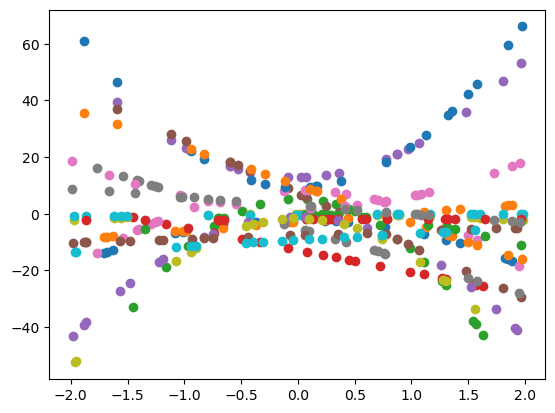

In [52]:
for i in range(N):
    plt.plot(X_train[i*p:(i+1)*p,0].detach().numpy(),Y[i*p:(i+1)*p].detach().numpy(),'o')

In [53]:
Y_mean = Y.mean()
Y_std = Y.std()

X_mean = X_train.mean()
X_std =X_train.std()

#X_train = (X_train-X_mean)/X_std
#X_test = (X_test-X_mean)/X_std

#Y=(Y-Y_mean)/Y_std
#Y_test=(Y_test-Y_mean)/Y_std

In [54]:
X_all_train = (torch.cat((X_train,torch.repeat_interleave(L_true,p,dim=0)),axis=1))
X_all_test = (torch.cat((X_test,torch.repeat_interleave(L_true,p,dim=0)),axis=1))


In [55]:
emulator=GPE.ensemble(X_all_train,Y,mean_func='zero',training_iter=1000)

0
1


In [56]:
emulator.R2(X_all_test,Y_test)

tensor([1.0000, 1.0000], grad_fn=<RsubBackward1>)

In [57]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)

In [58]:
LVemulator = LVM.LVE(XL_train,Y,0.001,p,N,1,training_iter=1000,lr=1e-4)

tensor(123720.8672, grad_fn=<NegBackward0>)


In [59]:
LVemulator.optimise(100000,lr=1e-5)

tensor(82008.7344, grad_fn=<NegBackward0>)
tensor(49439.9062, grad_fn=<NegBackward0>)
tensor(31049.7676, grad_fn=<NegBackward0>)
tensor(15649.3301, grad_fn=<NegBackward0>)
tensor(10079.3936, grad_fn=<NegBackward0>)
tensor(7304.0518, grad_fn=<NegBackward0>)
tensor(4980.9814, grad_fn=<NegBackward0>)
tensor(3009.3271, grad_fn=<NegBackward0>)
tensor(2271.4419, grad_fn=<NegBackward0>)
tensor(1781.7700, grad_fn=<NegBackward0>)
tensor(1401.3942, grad_fn=<NegBackward0>)
tensor(1101.5515, grad_fn=<NegBackward0>)
tensor(864.0388, grad_fn=<NegBackward0>)
tensor(676.0845, grad_fn=<NegBackward0>)
tensor(528.1808, grad_fn=<NegBackward0>)
tensor(411.8131, grad_fn=<NegBackward0>)
tensor(318.7698, grad_fn=<NegBackward0>)
tensor(244.1451, grad_fn=<NegBackward0>)
tensor(186.9848, grad_fn=<NegBackward0>)
tensor(142.8707, grad_fn=<NegBackward0>)
tensor(108.6378, grad_fn=<NegBackward0>)
tensor(80.5416, grad_fn=<NegBackward0>)
tensor(54.7301, grad_fn=<NegBackward0>)
tensor(29.8476, grad_fn=<NegBackward0>)
te

In [60]:
torch.cat(LVemulator.Ls,axis=1).shape

torch.Size([10, 202000])

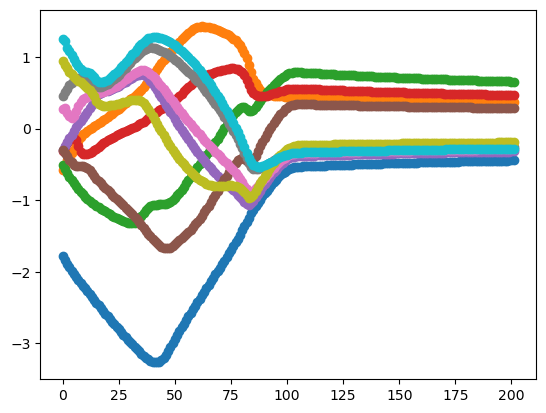

In [61]:
plt.plot(torch.cat(LVemulator.Ls,axis=1).T[::1000],'o')

In [79]:
XL_test = torch.cat((X_test,torch.repeat_interleave(LVemulator.L,p,dim=0)),axis=1)

In [80]:
LVemulator.L

tensor([[-0.4441, -0.1179],
        [ 0.3698, -0.7860],
        [ 0.6551,  0.7733],
        [ 0.4669, -0.1867],
        [-0.3197,  0.0900],
        [ 0.2861,  0.9834],
        [-0.2856, -0.0365],
        [-0.2576, -0.4681],
        [-0.1925,  0.3574],
        [-0.2794, -0.6091]], requires_grad=True)

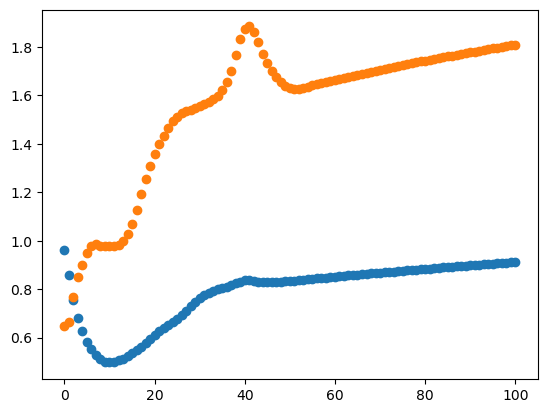

In [81]:
plt.plot(torch.cat(LVemulator.lengths,axis=1).T[::1000],'o')

In [82]:
LVemulator.predict(XL_test)

(tensor([[-1.1996e+01, -7.7023e+00],
         [-6.1133e+00, -5.9645e+00],
         [-9.6168e+00,  1.4836e+00],
         [-5.2422e+00, -9.0467e-02],
         [-1.6287e+01, -8.5224e+00],
         [-6.1613e+00, -5.9823e+00],
         [-2.2240e+00, -3.1164e+00],
         [-2.6013e+00, -3.7993e+00],
         [-2.2303e+00, -2.5211e+00],
         [-1.2451e+01,  2.1784e+00],
         [-1.3481e+01,  2.3964e+00],
         [-2.9845e+00, -4.1862e+00],
         [-1.0487e+01,  1.7145e+00],
         [-6.2927e+00,  3.7144e-01],
         [-5.9095e+00,  2.1313e-01],
         [-2.7077e+00, -1.7511e+00],
         [-3.6973e+00, -4.7238e+00],
         [-2.2020e+00, -3.0103e+00],
         [-1.6265e+01,  2.9297e+00],
         [-3.1402e+00, -4.3177e+00],
         [-3.9865e+01, -3.7370e-01],
         [-2.9320e+01, -2.3541e+01],
         [-1.2246e+01, -2.0486e+01],
         [-4.4146e+01, -2.5542e+01],
         [-3.7315e+01, -2.4666e+01],
         [-7.2472e+00, -1.9284e+01],
         [ 5.2236e+00, -1.1798e+01],
 

In [83]:
LVemulator.lengthscale

tensor([[0.9144],
        [1.8130]], requires_grad=True)

In [84]:
LVemulator.scale

tensor([9.9663, 9.2188], requires_grad=True)

In [85]:
LVemulator.MSE(XL_test,Y_test)

tensor([25.4393,  2.6375], grad_fn=<MeanBackward1>)

In [86]:
LVemulator.R2(XL_test,Y_test)

tensor([0.8222, 0.9407], grad_fn=<RsubBackward1>)

In [70]:
Y_test.std(axis=0)

tensor([20.5301, 12.5373])

In [71]:
Y_test

tensor([[-1.1976e+01, -7.6899e+00],
        [-6.1721e+00, -5.9313e+00],
        [-9.7317e+00,  1.4350e+00],
        [-5.2742e+00, -1.0173e-01],
        [-1.6187e+01, -8.6417e+00],
        [-6.2171e+00, -5.9488e+00],
        [-2.2210e+00, -3.1213e+00],
        [-2.5812e+00, -3.8071e+00],
        [-2.2262e+00, -2.5190e+00],
        [-1.2466e+01,  2.1482e+00],
        [-1.3459e+01,  2.3833e+00],
        [-2.9540e+00, -4.1916e+00],
        [-1.0575e+01,  1.6671e+00],
        [-6.3745e+00,  3.4741e-01],
        [-5.9776e+00,  1.9305e-01],
        [-2.6780e+00, -1.7412e+00],
        [-3.6676e+00, -4.7210e+00],
        [-2.1999e+00, -3.0146e+00],
        [-1.6281e+01,  2.9997e+00],
        [-3.1082e+00, -4.3222e+00],
        [-3.9868e+01, -2.8955e-01],
        [-2.9299e+01, -2.3528e+01],
        [-1.2368e+01, -2.0451e+01],
        [-4.4206e+01, -2.5646e+01],
        [-3.7240e+01, -2.4703e+01],
        [-7.3198e+00, -1.9260e+01],
        [ 5.2613e+00, -1.1817e+01],
        [-2.2039e+01, -2.232

In [72]:
for param_name, param in emulator.models[0].named_parameters():
    print(f'Parameter name: {param_name:42} ')

Parameter name: likelihood.noise_covar.raw_noise           
Parameter name: covar_module.raw_outputscale               
Parameter name: covar_module.base_kernel.raw_lengthscale   


In [73]:
emulator.models[0].covar_module.outputscale
emulator.models[0].covar_module.base_kernel.lengthscale

tensor([[ 2.1420,  3.6396, 33.5711]], grad_fn=<SoftplusBackward0>)

In [74]:
emulator.models[0].covar_module.outputscale.detach().clone()

tensor(48.7776)

In [75]:
rbf(X_all_train,X_all_train,1.,torch.tensor(1.))

tensor([[1.0000, 0.1161, 0.2956,  ..., 0.0829, 0.0391, 0.0089],
        [0.1161, 1.0000, 0.8762,  ..., 0.6545, 0.6264, 0.4543],
        [0.2956, 0.8762, 1.0000,  ..., 0.5861, 0.4706, 0.2564],
        ...,
        [0.0829, 0.6545, 0.5861,  ..., 1.0000, 0.9433, 0.6682],
        [0.0391, 0.6264, 0.4706,  ..., 0.9433, 1.0000, 0.8566],
        [0.0089, 0.4543, 0.2564,  ..., 0.6682, 0.8566, 1.0000]])

In [76]:
rbf(X_all_train,X_all_train,1.,torch.tensor(1.))-rbf2(X_all_train,X_all_train,1.,torch.tensor(1.))

tensor([[0.0000, 0.1026, 0.2082,  ..., 0.0761, 0.0375, 0.0089],
        [0.1026, 0.0000, 0.1085,  ..., 0.2261, 0.2340, 0.2479],
        [0.2082, 0.1085, 0.0000,  ..., 0.2426, 0.2491, 0.1907],
        ...,
        [0.0761, 0.2261, 0.2426,  ..., 0.0000, 0.0535, 0.2217],
        [0.0375, 0.2340, 0.2491,  ..., 0.0535, 0.0000, 0.1228],
        [0.0089, 0.2479, 0.1907,  ..., 0.2217, 0.1228, 0.0000]])

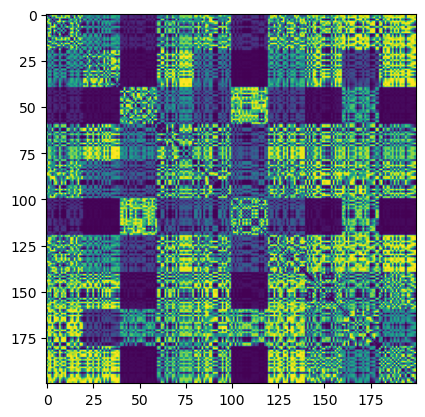

In [77]:
plt.imshow(rbf(X_all_train,X_all_train,1.,torch.tensor(1.))-rbf2(X_all_train,X_all_train,1.,torch.tensor(1.)))

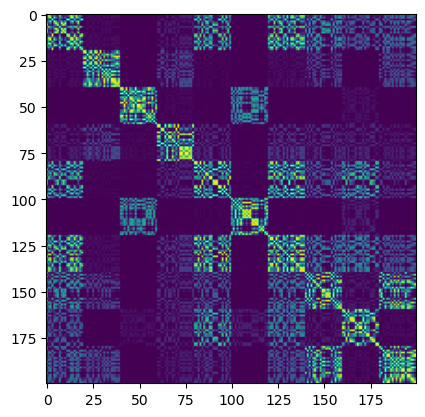

In [78]:
plt.imshow(rbf2(X_all_train,X_all_train,1.,torch.tensor(1.)))

In [ ]:
emulator.R2(X_all_test,Y_test)

In [ ]:
def cost(y,XL,scaling1,lengthscale1,scaling2,lengthscale2,sigma2,L_dim,mean=0):
    
    K1=rbf(XL,XL,scaling1,lengthscale1)+sigma2*torch.eye(XL.shape[0])
    K2=rbf(XL,XL,scaling2,lengthscale2)+sigma2*torch.eye(XL.shape[0])
    #K_inv=torch.kron(torch.linalg.inv(K_x),torch.linalg.inv(K_L))
    #K_inv=torch.kron(torch.linalg.inv(K_L),torch.linalg.inv(K_x))
    #print(torch.linalg.det(K))
    c = multivariate_ll(y[:,[0]],mean,K1) + multivariate_ll(y[:,[1]],mean,K2)+ multivariate_ll(XL[:,L_dim:],0,torch.eye(XL.shape[0])) # multivariate_ll(torch.repeat_interleave(L,x.shape[0])[:,None],0,torch.eye(inp.shape[0]))
    return -c

In [ ]:
L = torch.rand(L_true.shape[0],L_true.shape[1]).clone().detach().requires_grad_(True)

In [ ]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
L_orig = L.clone().detach()
#L =L_true.clone().detach().requires_grad_(True)
scaling1 = torch.rand(1).clone().detach().requires_grad_(True)
lengthscale1 = torch.rand(X_train.shape[1]).clone().detach().requires_grad_(True)
lengthscale_in1=torch.tensor([lengthscale[0],4])

scaling2 = torch.rand(1).clone().detach().requires_grad_(True)
lengthscale2 = torch.rand(X_train.shape[1]).clone().detach().requires_grad_(True)
lengthscale_in2=torch.tensor([lengthscale[0],4])


scaling_true1 = emulator.models[0].covar_module.outputscale.detach().clone().requires_grad_(True)#torch.rand(1).clone().detach().requires_grad_(True)
lengthscale_true1 = torch.rand(X_train.shape[1]).clone().detach().requires_grad_(True)

scaling_true2 = emulator.models[1].covar_module.outputscale.detach().clone().requires_grad_(True)#torch.rand(1).clone().detach().requires_grad_(True)
lengthscale_true2 = emulator.models[1].covar_module.base_kernel.lengthscale.detach().clone().requires_grad_(True) #torch.rand(X_train.shape[1]+L_true.shape[1]).clone().detach().requires_grad_(True)

#lengthscale=lengthscale_true.clone().detach().requires_grad_(True)
#scaling=scaling_true.clone().detach().requires_grad_(True)

sigma2 = torch.tensor([0.001]).clone().detach().requires_grad_(True)
mean = torch.rand(1).clone().detach().requires_grad_(True)
mean=0

In [ ]:
XL_test = torch.cat((X_test,torch.repeat_interleave(L_true,p,dim=0)),axis=1)
XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)

XL_true_test = torch.cat((X_test,torch.repeat_interleave(L_true,p,dim=0)),axis=1)
XL_true_train = torch.cat((X_train,torch.repeat_interleave(L_true,p,dim=0)),axis=1)

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,XL_test[i*p:(i+1)*p],XL_train,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y[:,0],XL_true_test[i*p:(i+1)*p],XL_true_train,scaling_true1,lengthscale_true1,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,0]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,0]*Y_std+Y_mean).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,0]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,0]*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XL_test,XL_train,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XL_true_test,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
cost(Y,XL_train,scaling1,lengthscale1,scaling2,lengthscale2,sigma2,L_dim=1)

In [ ]:
gd = torch.optim.SGD([scaling_true1,lengthscale_true], lr=1e-5)
history_gd = []

for i in range(100000):
    gd.zero_grad()
    objective = cost(Y,XL_true_train,scaling_true,lengthscale_true,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    if i%100 ==0:
        print(objective)
    if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .00000000000001):
        print("Convergence achieved in ", i+1, " iterations") 
        print("-LogL Value: ", objective.item())
        break


## lengthscale=4

In [ ]:
history_gd = []
scales=[]
lengths=[]
Ls=[]

In [ ]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
scaling1 = (2*torch.rand(1)).clone().detach().requires_grad_(True)
lengthscale1 = (2*torch.rand(X_train.shape[1])).clone().detach().requires_grad_(True)
lengthscale_in1=torch.cat([lengthscale,torch.tensor([4])])

scaling2 = (2*torch.rand(1)).clone().detach().requires_grad_(True)
lengthscale2 = (2*torch.rand(X_train.shape[1])).clone().detach().requires_grad_(True)
lengthscale_in2=torch.cat([lengthscale,torch.tensor([4])])

In [ ]:
gd = torch.optim.Adam([L,scaling1,lengthscale1,scaling2,lengthscale2], lr=1e-5)
for i in range(1000000):
    lengthscale_in1=torch.cat([lengthscale1,torch.tensor([4,4])])
    lengthscale_in2=torch.cat([lengthscale2,torch.tensor([4,4])])
    gd.zero_grad()
    objective = cost(Y,XL_train,scaling1,lengthscale_in1,scaling2,lengthscale_in2,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    scales.append(scaling.clone().detach())
    lengths.append(lengthscale.clone().detach())
    Ls.append(L.clone().detach())
    XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)
    
    if i%1000 ==0:
        XL_test = torch.cat((X_test,torch.repeat_interleave(L,p,dim=0)),axis=1)
        m_p,K_p = posterior_theta(Y,XL_test,XL_train,scaling1,lengthscale_in1,sigma2,mean)
        R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
        print(objective,R2,scaling)
        
    #if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .000000000000000000000001):
        #print("Convergence achieved in ", i+1, " iterations") 
        #print("-LogL Value: ", objective.item())
        #break

In [ ]:
plt.plot(history_gd)

In [ ]:
torch.cat(Ls,axis=0).shape

In [ ]:
plt.plot(torch.cat(Ls,axis=0).detach().numpy(),'o')

In [ ]:
torch.cat(lengths).shape

In [ ]:
plt.plot(torch.cat(lengths).detach().numpy(),'o')

In [ ]:
m_p2,K_p = posterior_theta(Y,XXLL,XL_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_train[0:10,1].detach().numpy(),XL_train[0:10,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[0:10,1].detach().numpy(),XL_true_train[0:10,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

## lengthscale=1

In [ ]:
history_gd = []
scales=[]
lengths=[]
Ls=[]

In [ ]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
scaling = (2*torch.rand(1)).clone().detach().requires_grad_(True)
lengthscale = (2*torch.rand(X_train.shape[1])).clone().detach().requires_grad_(True)
lengthscale_in=torch.cat([lengthscale,torch.tensor([4])])


In [ ]:
gd = torch.optim.Adam([L,scaling,lengthscale], lr=1e-5)
for i in range(1000000):
    lengthscale_in=torch.cat([lengthscale,torch.tensor([1])])
    gd.zero_grad()
    objective = cost(Y,XL_train,scaling,lengthscale_in,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    scales.append(scaling.clone().detach())
    lengths.append(lengthscale.clone().detach())
    Ls.append(L.clone().detach())
    XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)
    
    if i%1000 ==0:
        XL_test = torch.cat((X_test,torch.repeat_interleave(L,p,dim=0)),axis=1)
        m_p,K_p = posterior_theta(Y,XL_test,XL_train,scaling,lengthscale_in,sigma2,mean)
        R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
        print(objective,R2,scaling)
        
    #if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .000000000000000000000001):
        #print("Convergence achieved in ", i+1, " iterations") 
        #print("-LogL Value: ", objective.item())
        #break

In [ ]:
plt.plot(history_gd)

In [ ]:
torch.cat(Ls,axis=1)

In [ ]:
plt.plot(torch.cat(Ls,axis=1).T.detach().numpy())

In [ ]:
torch.cat(lengths).shape

In [ ]:
plt.plot(torch.cat(lengths).detach().numpy(),'o')

In [ ]:
m_p2,K_p = posterior_theta(Y,XXLL,XL_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_train[30:40,1].detach().numpy(),XL_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[30:40,1].detach().numpy(),XL_true_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

## Can we get to the true values?

In [ ]:
history_gd = []
scales=[]
lengths=[]
Ls=[]

In [ ]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
scaling = (torch.rand(1)).clone().detach().requires_grad_(True)
lengthscale = torch.rand(X_train.shape[1]+L_true.shape[1]).clone().detach().requires_grad_(True)

In [ ]:
gd = torch.optim.Adam([scaling,lengthscale], lr=1e-5)
for i in range(500000):
    gd.zero_grad()
    objective = cost(Y,XL_true_train,scaling,lengthscale,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    scales.append(scaling.clone().detach())
    lengths.append(lengthscale.clone().detach())
    Ls.append(L.clone().detach())
    
    if i%1000 ==0:
        m_p,K_p = posterior_theta(Y,XL_true_test,XL_true_train,scaling,lengthscale,sigma2,mean)
        R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
        print(objective,R2,scaling)
        
    #if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .000000000000000000000001):
        #print("Convergence achieved in ", i+1, " iterations") 
        #print("-LogL Value: ", objective.item())
        #break

In [ ]:
plt.plot(history_gd)

In [ ]:
torch.cat(Ls,axis=1)

In [ ]:
plt.plot(torch.cat(Ls,axis=1).T.detach().numpy())

In [ ]:
torch.cat(lengths).shape

In [ ]:
plt.plot(torch.cat(lengths).detach().numpy(),'o')

In [ ]:
m_p2,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[30:40,1].detach().numpy(),XL_true_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[30:40,1].detach().numpy(),XL_true_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

In [ ]:
plt.plot(torch.tensor(scales).detach().numpy())

In [ ]:
scaling_true

In [ ]:
scaling

In [ ]:
Y_test.std()

In [ ]:

print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XL_true_test,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XL_train,XL_train,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0)/(Y*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0),(Y*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XL_true_train,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0)/(Y*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0),(Y*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling,lengthscale,sigma2,mean)

In [ ]:
XXLL.min(axis=0)

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[:,1].detach().numpy(),XL_true_train[:,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,0].detach().numpy(),XL_test[:,1].detach().numpy(),'o',color='b')
plt.colorbar()

In [ ]:
XL_train

In [ ]:



m_p2,K_p = posterior_theta(Y,XXLL,XL_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_train[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

In [ ]:
lengthscale

In [ ]:
L

In [ ]:
scaling

In [ ]:
lengthscale_true

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow((m_p.reshape(100,100).detach().numpy()-m_p2.reshape(100,100).detach().numpy())**2,origin='lower',extent=[lmin,lmax,xmin,xmax])
#plt.plot(XL_train[:,0].detach().numpy(),XL_train[:,1].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,0].detach().numpy(),XL_test[:,1].detach().numpy(),'o',color='b')
plt.colorbar()

In [ ]:
plt.imshow(emulator.predict(XXLL).reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.colorbar()

In [ ]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy()-emulator.predict(XXLL).reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.colorbar()

In [ ]:
L_true

In [ ]:
L

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,XL_test[i*p:(i+1)*p],XL_train,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2)

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,XL_test[i*p:(i+1)*p],XL_train,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p-(Y_test[i*p:(i+1)*p,:]))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2)

### Test 2

In [ ]:
N = 10 #number of systems
p = 20 #observations per system
alpha=10
beta=-7
zeta=5

In [ ]:
L_true=torch.FloatTensor(N, 2).uniform_(-1, 1)

In [ ]:
L_true[0]

In [ ]:
multivariate_ll(L_true,0,torch.eye(N),K_inv=None)

In [ ]:

import scipy
np.sum(scipy.stats.multivariate_normal.logpdf(L_true.T.detach().numpy(),cov=np.eye(N)))

In [ ]:
X_train=torch.torch.FloatTensor(N*p, 2).uniform_(-1, 1)
X_test=torch.torch.FloatTensor(N*p, 2).uniform_(-1, 1)

In [ ]:
L_true[[0]][0]

In [ ]:
def true_func(X,L,alpha,beta,zeta):
    tf = alpha*X[:,[0]]*X[:,[ 0]]*L[:,0]+beta*L[:,1]*X[:,[ 1]]+zeta+torch.normal(0,0.01*torch.ones(X.shape[0],1))
    return tf

In [ ]:
y=[]
y_test = []
for i in range(N):
    y.append(true_func(X_train[i*p:(i+1)*p],L_true[[i]],alpha,beta,zeta))
    y_test.append(true_func(X_test[i*p:(i+1)*p],L_true[[i]],alpha,beta,zeta))

In [ ]:
Y=torch.cat(y)
Y_test=torch.cat(y_test)

In [ ]:
Y.shape

In [ ]:
Y_mean = Y.mean()
Y_std = Y.std()

X_mean = X_train.mean()
X_std =X_train.std()

X_train = (X_train-X_mean)/X_std
X_test = (X_test-X_mean)/X_std

In [ ]:
X_train[i*p:(i+1)*p,0].shape

In [ ]:
emulators=[]
for i in range(N):
    emulators.append(GPE.ensemble(X_train[i*p:(i+1)*p,:],Y[i*p:(i+1)*p],mean_func='zero'))

In [ ]:
for i in range(N):
    print(emulators[i].R2(X_test[i*p:(i+1)*p,:],(Y_test[i*p:(i+1)*p])))

In [ ]:
Y=(Y-Y_mean)/Y_std
Y_test=(Y_test-Y_mean)/Y_std

In [ ]:
def cost(y,X,L,scaling,lengthscale,sigma2,p,mean=0):
    

    K=rbf(X,L,X,L,scaling,lengthscale,p,p)+sigma2*torch.eye(X.shape[0])
    
    #K_inv=torch.kron(torch.linalg.inv(K_x),torch.linalg.inv(K_L))
    #K_inv=torch.kron(torch.linalg.inv(K_L),torch.linalg.inv(K_x))
    #print(torch.linalg.det(K))
    c = multivariate_ll(y,mean,K) + multivariate_ll(L,0,torch.eye(L.shape[0])) # multivariate_ll(torch.repeat_interleave(L,x.shape[0])[:,None],0,torch.eye(inp.shape[0]))
    return -c

In [ ]:
L = torch.rand(L_true.shape[0],L_true.shape[1]).clone().detach().requires_grad_(True)

In [ ]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
#L =L_true.clone().detach().requires_grad_(True)
scaling = torch.rand(1).clone().detach().requires_grad_(True)
lengthscale = torch.rand(X_train.shape[1]+L_true.shape[1]).clone().detach().requires_grad_(True)
sigma2 = torch.tensor([0.000001]).clone().detach().requires_grad_(True)
mean = torch.rand(1).clone().detach().requires_grad_(True)
mean=0

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y[i*p:(i+1)*p],X_test[i*p:(i+1)*p],L[[i]],p,X_train[i*p:(i+1)*p],L[[i]],p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2)

In [ ]:
cost(Y,X_train,L,scaling,lengthscale,sigma2,p)

In [ ]:
#plt.imshow(rbf(X,L,X,L,scaling,lengthscale,p,p).detach().numpy())

In [ ]:
plt.imshow(rbf(X_train,L,X_train,L,scaling,lengthscale,p,p).detach().numpy())

In [ ]:
for i in range(N):
    plt.plot(X_train[i*p:(i+1)*p,0],Y[i*p:(i+1)*p],'o')

In [ ]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p)

In [ ]:
gd = torch.optim.Adam([L,scaling,lengthscale], lr=1e-5)
history_gd = []

for i in range(100000):
    gd.zero_grad()
    objective = cost(Y,X_train,L,scaling,lengthscale,sigma2,p)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    if i%1000 ==0:
        print(objective)
    if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .0000000000000000000001):
        print("Convergence achieved in ", i+1, " iterations") 
        print("-LogL Value: ", objective.item())
        break


In [ ]:
L_true

In [ ]:
L

In [ ]:
lengthscale


In [ ]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p,mean)

In [ ]:
cost(Y,X_train,L,scaling,lengthscale,sigma2,p,mean)

In [ ]:
mean

In [ ]:
m_p,K_p = posterior_theta(Y,X_test,L,p,X_train,L,p,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2)

In [ ]:
X_test[i*p:(i+1)*p:,].shape

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,X_test[i*p:(i+1)*p],L[[i]],p,X_train,L,p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2)

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,X_test[i*p:(i+1)*p],L_true[[i]],p,X_train,L_true,p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2)

In [ ]:
for i in range(N):
    print(emulators[i].R2(X_test[i*p:(i+1)*p,:],(Y_test[i*p:(i+1)*p])*Y_std+Y_mean))


In [ ]:
cost(Y,X_train,L,scaling,lengthscale,sigma2,p)

In [ ]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p)

In [ ]:
#plt.imshow(rbf(X,L,X,L,scaling,lengthscale,p,p).detach().numpy())

In [ ]:
plt.imshow(rbf(X_train,L,X_train,L,scaling,lengthscale,p,p).detach().numpy())

In [ ]:
for i in range(N):
    plt.plot(X_train[i*p:(i+1)*p,0],Y[i*p:(i+1)*p],'o')

In [ ]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p)

In [ ]:
gd = torch.optim.Adam([L,scaling,lengthscale], lr=1e-5)
history_gd = []

for i in range(100000):
    gd.zero_grad()
    objective = cost(Y,X_train,L,scaling,lengthscale,sigma2,p)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    if i%1000 ==0:
        print(objective)
    if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .00000001):
        print("Convergence achieved in ", i+1, " iterations") 
        print("-LogL Value: ", objective.item())
        break


In [ ]:
L_true

In [ ]:
L

In [ ]:
m_p,K_p = posterior_theta(Y,X_test,L,p,X_train,L,p,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2)

In [ ]:
X_test[i*p:(i+1)*p:,].shape

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y[i*p:(i+1)*p],X_test[i*p:(i+1)*p],L[[i]],p,X_train[i*p:(i+1)*p],L[[i]],p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(m_p[0],R2)

In [ ]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y[i*p:(i+1)*p],X_test[i*p:(i+1)*p],L_true[[i]],p,X_train[i*p:(i+1)*p],L_true[[i]],p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(m_p[0],R2)

In [ ]:
for i in range(N):
    print(emulators[i].R2(X_test[i*p:(i+1)*p,:],(Y_test[i*p:(i+1)*p])*Y_std+Y_mean))


In [ ]:
p_new = 20
X_new=torch.torch.FloatTensor(p_new, 1).uniform_(-1, 1)
L_new =torch.normal(0,torch.ones(1,L_true.shape[1]))
#L_new=L_true[[1]]
Y_new=true_func(X_new,L_new,alpha,beta,zeta)

Y_new_mean = Y_new.mean()
Y_new_std = Y_new.std()

Y_new = (Y_new-Y_mean)/Y_std

In [ ]:
plt.plot(X_new[:,0].detach().numpy(),Y_new.detach().numpy(),'o')

In [ ]:
def cf_cost(Y_new,X_new,L_new,Y_train,X_train,L_train,scaling,lengthscale,sigma2,p_train,p_new,mean):
    
    
    mean_p,K_p = posterior_theta(Y_train,X_new,L_new,p_new,X_train,L_train,p_train,scaling,lengthscale,sigma2,mean)
    
    #K_inv=torch.kron(torch.linalg.inv(K_x),torch.linalg.inv(K_L))
    #K_inv=torch.kron(torch.linalg.inv(K_L),torch.linalg.inv(K_x))
    #print(torch.linalg.det(K))
    c = multivariate_ll(Y_new,mean_p,K_p)  + multivariate_ll(L_new,0,torch.eye(L_new.shape[0])) # multivariate_ll(torch.repeat_interleave(L,x.shape[0])[:,None],0,torch.eye(inp.shape[0]))
    #print(multivariate_ll(Y_new,mean_p,K_p))
    #print(multivariate_ll(L_new,0,torch.eye(L_new.shape[0])))
    return -c

In [ ]:
cf_cost(Y_new,X_new,L_new,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)

In [ ]:
mean_p,K_p = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)

In [ ]:
plt.imshow(K_p.detach().numpy())

In [ ]:
mean_p

In [ ]:
Y_new

In [ ]:
L_cf =torch.normal(0,torch.ones(1,L_true.shape[1])).clone().detach().requires_grad_(True)
#L_cf = (L[[1]]).clone().detach().requires_grad_(True)

In [ ]:
cf_cost(Y_new,X_new,L_cf,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)

In [ ]:

cf = torch.optim.Adam([L_cf], lr=1e-5)
history_cf = []

for i in range(100000):
    cf.zero_grad()
    objective = cf_cost(Y_new,X_new,L_cf,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)
    objective.backward()
    cf.step()
    history_cf.append(objective.item())
    if i%1000 ==0:
        m_new, K_new = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)
        print(1-(((m_new-Y_new)**2).mean()/Y_new.std()**2),objective)

    if (i>1) and (np.abs(history_cf[-1] - history_cf[-2]) < .00000000001):
        print("Convergence achieved in ", i+1, " iterations")
        print("-LogL Value: ", objective.item())
        break


In [ ]:
L_cf

In [ ]:
L[[1]]

In [ ]:
m_new, K_new = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)

In [ ]:
K_new.detach().numpy()

In [ ]:
multivariate_ll(Y_new,m_new, K_new) + multivariate_ll(L_cf,0,torch.eye(L_new.shape[0]))

In [ ]:
multivariate_ll(Y_new,m_new, K_new) 

In [ ]:
multivariate_ll(L_cf,0,torch.eye(L_new.shape[0]))

In [ ]:
1-(((m_new-Y_new)**2).mean())/Y_new.std()

In [ ]:
m_new

In [ ]:
Y_new

In [ ]:
mean